<b><font color="SteelBlue" size="+3">Anticipez les besoins en consommation de bâtiments 2</font></b>

Ce notebook est la suite du notebook d'exploration des données Deveau_Estelle_1_notebook_exploratoire_022024

# Introduction

## Imports

In [1]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
import time

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## Data

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Deveau_Estelle_1_notebook_exploratoire_022024.ipynb',
 'Deveau_Estelle_2_notebook_prediction_EnergyUse_022024.ipynb',
 'Map_of_Seattle,_divided_by_districts.png',
 'svg']

In [3]:
os.listdir("data/cleaned/")

['df_cleaned.csv']

In [4]:
path     = "./data/cleaned/"
filename = "df_cleaned.csv"

In [5]:
df = pd.read_csv(path + filename)
df.head()

,TotalGHGEmissions,SiteEnergyUseWN(kBtu),Log_TotalGHGEmissions,Log_SiteEnergyUseWN,NumberofBuildings,NumberofFloors,BuildingType,NumberOfPropertyUseTypes,PropertyGFATotal,LargestPropertyUseTypeGFA_pct,...,PropertyGFAParking_pct,BuildingAge,GroupedNeighborhood,GroupedLargType,GroupedSecondLargType,GroupedThirdLargType,SteamUse_pct,Electricity_pct,NaturalGas_pct,ENERGYSTARScore
0,249.98,7456910.0,5.521381,15.824652,1.0,12,NonResidential,1,88434,100.000000,...,0.000000,89,commercial_industrial,D - Résidences,X - Non classifie,X - Non classifie,26.872820,52.917723,17.117720,60.0
1,295.86,8664479.0,5.689886,15.974742,1.0,11,NonResidential,3,103566,80.991831,...,14.545314,20,commercial_industrial,D - Résidences,C - Commerce resto loisirs,X - Non classifie,0.000000,37.426959,59.381320,61.0
2,2089.28,73937112.0,7.644575,18.118725,1.0,41,NonResidential,1,956110,79.362597,...,20.637403,47,commercial_industrial,D - Résidences,X - Non classifie,X - Non classifie,29.168781,66.984851,2.020366,43.0
3,286.43,6946800.5,5.657494,15.753792,1.0,10,NonResidential,1,61320,100.000000,...,0.000000,90,commercial_industrial,D - Résidences,X - Non classifie,X - Non classifie,31.877211,39.858983,26.072621,56.0
4,176.14,6062767.5,5.171279,15.617677,1.0,11,NonResidential,1,83008,100.000000,...,0.000000,90,commercial_industrial,D - Résidences,X - Non classifie,X - Non classifie,0.000000,46.368511,48.617731,27.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   TotalGHGEmissions                    1109 non-null   float64
 1   SiteEnergyUseWN(kBtu)                1109 non-null   float64
 2   Log_TotalGHGEmissions                1109 non-null   float64
 3   Log_SiteEnergyUseWN                  1109 non-null   float64
 4   NumberofBuildings                    1109 non-null   float64
 5   NumberofFloors                       1109 non-null   int64  
 6   BuildingType                         1109 non-null   object 
 7   NumberOfPropertyUseTypes             1109 non-null   int64  
 8   PropertyGFATotal                     1109 non-null   int64  
 9   LargestPropertyUseTypeGFA_pct        1109 non-null   float64
 10  SecondLargestPropertyUseTypeGFA_pct  1109 non-null   float64
 11  ThirdLargestPropertyUseTypeGFA

In [7]:
df.describe()

,TotalGHGEmissions,SiteEnergyUseWN(kBtu),Log_TotalGHGEmissions,Log_SiteEnergyUseWN,NumberofBuildings,NumberofFloors,NumberOfPropertyUseTypes,PropertyGFATotal,LargestPropertyUseTypeGFA_pct,SecondLargestPropertyUseTypeGFA_pct,ThirdLargestPropertyUseTypeGFA_pct,PropertyGFAParking_pct,BuildingAge,SteamUse_pct,Electricity_pct,NaturalGas_pct,ENERGYSTARScore
count,1109.000000,1.109000e+03,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1.109000e+03,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,1109.000000,701.000000
mean,169.832362,8.178016e+06,3.877767,14.856429,1.253381,4.032462,1.833183,1.109784e+05,88.746042,8.113658,1.502393,1.637907,58.504959,2.057110,65.397990,27.272598,63.078459
std,644.438367,3.223506e+07,1.515763,1.291348,3.555618,6.829858,1.182048,3.417603e+05,16.889800,13.748904,4.954547,5.154676,31.555596,8.655708,27.444465,24.483969,28.737250
min,0.400000,5.811420e+04,-0.916291,10.970165,1.000000,1.000000,1.000000,1.128500e+04,33.333333,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,18.810000,1.186733e+06,2.934389,13.986715,1.000000,1.000000,1.000000,2.708500e+04,80.896925,0.000000,0.000000,0.000000,35.000000,0.000000,43.086418,0.000000,43.000000
50%,46.450000,2.394062e+06,3.838376,14.688502,1.000000,2.000000,1.000000,4.339000e+04,100.000000,0.000000,0.000000,0.000000,55.000000,0.000000,64.341640,26.074393,70.000000
75%,132.710000,6.211750e+06,4.888166,15.641953,1.000000,4.000000,2.000000,8.726200e+04,100.000000,12.663707,0.000000,0.000000,88.000000,0.000000,94.824479,47.645524,88.000000
max,12307.160000,8.739237e+08,9.417936,20.588504,111.000000,76.000000,11.000000,9.320156e+06,100.000000,50.000000,33.333333,27.637240,116.000000,64.773098,103.872233,100.000000,100.000000


Nous allons commencer par chercher un modèle de ML pour prédire le SiteEnergyUseWN

Dans un premier temps, nous allons travailler en excluant l'ENERGYSTARScore puis nous ferons une comparaison avec son utilisation.

# Modelisation sans l'Energy Star Score

## Data preparation

### Séparation des données

In [8]:
# Sélection des variables explicatives et des variables cibles
features = df.drop(['Log_TotalGHGEmissions', 'Log_SiteEnergyUseWN', 'TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)', 'ENERGYSTARScore'], axis=1)
target = df['Log_SiteEnergyUseWN']

# Transformation des variables catégorielles en variables numériques (encodage one-hot)
features = pd.get_dummies(features)

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
# Conservez les noms des colonnes dans une variable avant la mise à l'échelle
column_names = X_train.columns

# Affichage des dimensions des ensembles d'entraînement et de test
X_train.shape, X_test.shape

((887, 43), (222, 43))

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 887 entries, 616 to 860
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   NumberofBuildings                                 887 non-null    float64
 1   NumberofFloors                                    887 non-null    int64  
 2   NumberOfPropertyUseTypes                          887 non-null    int64  
 3   PropertyGFATotal                                  887 non-null    int64  
 4   LargestPropertyUseTypeGFA_pct                     887 non-null    float64
 5   SecondLargestPropertyUseTypeGFA_pct               887 non-null    float64
 6   ThirdLargestPropertyUseTypeGFA_pct                887 non-null    float64
 7   PropertyGFAParking_pct                            887 non-null    float64
 8   BuildingAge                                       887 non-null    int64  
 9   SteamUse_pct            

In [10]:
X_train.head()

,NumberofBuildings,NumberofFloors,NumberOfPropertyUseTypes,PropertyGFATotal,LargestPropertyUseTypeGFA_pct,SecondLargestPropertyUseTypeGFA_pct,ThirdLargestPropertyUseTypeGFA_pct,PropertyGFAParking_pct,BuildingAge,SteamUse_pct,...,GroupedSecondLargType_G - Autres,GroupedSecondLargType_X - Non classifie,GroupedThirdLargType_A - Data Center Sante,GroupedThirdLargType_B - Public et culturel,GroupedThirdLargType_C - Commerce resto loisirs,GroupedThirdLargType_D - Résidences,GroupedThirdLargType_E - Industrie et entrepots,GroupedThirdLargType_F - Bureaux et services,GroupedThirdLargType_G - Autres,GroupedThirdLargType_X - Non classifie
616,1.0,1,2,21101,87.071703,12.928297,0.0,0.0,27,0.0,...,False,False,False,False,False,False,False,False,False,True
990,1.0,1,3,35017,65.908258,34.091742,0.0,0.0,47,0.0,...,False,False,False,False,False,False,False,False,False,True
706,1.0,2,3,20088,82.124617,17.875383,0.0,0.0,37,0.0,...,False,False,False,False,False,False,False,False,False,True
777,1.0,1,1,25880,100.000000,0.000000,0.0,0.0,72,0.0,...,False,True,False,False,False,False,False,False,False,True
732,1.0,1,1,23706,100.000000,0.000000,0.0,0.0,53,0.0,...,False,True,False,False,False,False,False,False,False,True


In [11]:
y_train.head()

616    13.616441
990    14.147898
706    12.729428
777    12.001260
732    13.031307
Name: Log_SiteEnergyUseWN, dtype: float64

### Standardisation

In [12]:
# Initialisation du StandardScaler
scaler = StandardScaler()

In [13]:
columns_to_scale=['NumberofBuildings','NumberofFloors',	'NumberOfPropertyUseTypes', 'PropertyGFATotal', 'LargestPropertyUseTypeGFA_pct', 
                  'SecondLargestPropertyUseTypeGFA_pct', 'ThirdLargestPropertyUseTypeGFA_pct',
                  'BuildingAge', 'SteamUse_pct', 'Electricity_pct', 'NaturalGas_pct']

In [14]:
# Séparer les colonnes à normaliser
X_train_to_scale = X_train[columns_to_scale]
X_test_to_scale = X_test[columns_to_scale]

# Appliquer la normalisation sur ces colonnes
X_train_scaled = scaler.fit_transform(X_train_to_scale)
X_test_scaled = scaler.transform(X_test_to_scale)

# Merge
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=columns_to_scale, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=columns_to_scale, index=X_test.index)
X_train_final = X_train.drop(columns=columns_to_scale).join(X_train_scaled_df)
X_test_final = X_test.drop(columns=columns_to_scale).join(X_test_scaled_df)


In [15]:
X_train_final.head()

,PropertyGFAParking_pct,BuildingType_Campus,BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,BuildingType_SPS-District K-12,GroupedNeighborhood_commercial_industrial,GroupedNeighborhood_residential,GroupedNeighborhood_urban_core,GroupedLargType_A - Data Center Sante,...,NumberofFloors,NumberOfPropertyUseTypes,PropertyGFATotal,LargestPropertyUseTypeGFA_pct,SecondLargestPropertyUseTypeGFA_pct,ThirdLargestPropertyUseTypeGFA_pct,BuildingAge,SteamUse_pct,Electricity_pct,NaturalGas_pct
616,0.0,False,True,False,False,False,True,False,False,False,...,-0.456079,0.151962,-0.239709,-0.095229,0.335021,-0.303915,-1.001254,-0.252329,-1.603876,1.385963
990,0.0,False,True,False,False,False,True,False,False,False,...,-0.456079,1.038743,-0.201472,-1.339196,1.859290,-0.303915,-0.358114,-0.252329,-0.014706,0.036287
706,0.0,False,True,False,False,False,False,False,True,False,...,-0.293351,1.038743,-0.242493,-0.386014,0.691329,-0.303915,-0.679684,-0.252329,1.140506,-1.093915
777,0.0,False,True,False,False,False,True,False,False,False,...,-0.456079,-0.734819,-0.226578,0.664684,-0.596122,-0.303915,0.445812,-0.252329,1.255812,-1.093915
732,0.0,False,True,False,False,False,True,False,False,False,...,-0.456079,-0.734819,-0.232552,0.664684,-0.596122,-0.303915,-0.165172,-0.252329,-0.960203,0.883643


## Préparation des métriques

## Tests de modèles

In [16]:
# Liste de modèles à évaluer
models = [
    ('DummyRegressorMedian', DummyRegressor(strategy='median')),
    ('LinearRegression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet(random_state=0)),
    ('RandomForest', RandomForestRegressor(random_state=0)),
    ('GradientBoostingReg', GradientBoostingRegressor(random_state=0)),
    ('SVR', SVR())
]

# Tableau pour collecter les résultats
results = []

# Évaluer chaque modèle
for name, model in models:
    # Entraîner le modèle
    start_time = time.time() 
    model.fit(X_train_final, y_train)
    end_time = time.time()  # Enregistre le temps de fin
    duration = end_time - start_time  # Calcule la durée
    
    # Prédire sur l'ensemble de test
    y_pred = model.predict(X_test_final)
    
    # Calculer les métriques
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # RMSE CV
    scores_rmse = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_cv = np.sqrt(-scores_rmse).mean()
    
    # R2 CV
    scores_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    r2_cv = scores_r2.mean()
    r2_cv_std = scores_r2.std() 
    
    results.append((name, rmse, mae, r2, rmse_cv, r2_cv, r2_cv_std, duration))


In [17]:
# Convertir les résultats en DataFrame
df_results = pd.DataFrame(results, columns=['Modèle', 'RMSE', 'MAE', 'R2', 'RMSE CV', 'R2 CV', 'R2 CV Std', 'Temps de calcul'])
df_sorted_by_performance = df_results.sort_values(by=['RMSE', 'R2 CV', 'MAE'], ascending=[True, False, True])

df_sorted_by_performance

,Modèle,RMSE,MAE,R2,RMSE CV,R2 CV,R2 CV Std,Temps de calcul
5,RandomForest,0.575116,0.434357,0.791195,0.698481,0.706090,0.028446,0.773397
6,GradientBoostingReg,0.606082,0.459612,0.768104,0.664311,0.735516,0.010623,0.237522
7,SVR,0.776584,0.599994,0.619278,0.865252,0.550576,0.025797,0.032530
2,Ridge,0.851337,0.659737,0.542454,1.222720,-0.048835,1.129085,0.001001
1,LinearRegression,0.853848,0.661080,0.539752,1.222913,-0.045911,1.116958,0.018352
4,ElasticNet,1.183614,0.933498,0.115595,1.286946,-0.063878,0.809950,0.002002
3,Lasso,1.210077,0.949629,0.075605,1.327958,-0.148457,0.943961,0.002504
0,DummyRegressorMedian,1.278830,0.981936,-0.032422,1.307694,-0.021854,0.016661,0.000000


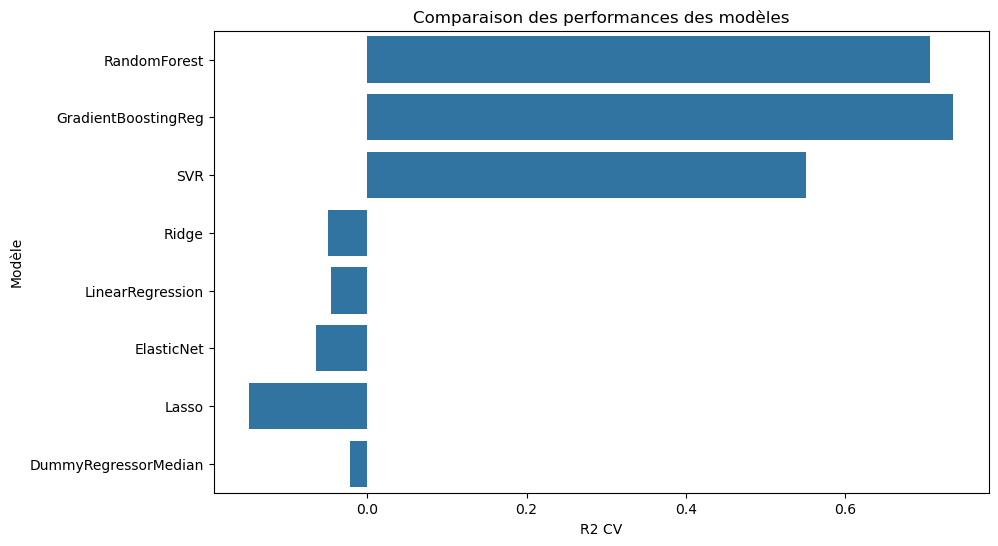

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x='R2 CV', y='Modèle', data=df_sorted_by_performance)
plt.title('Comparaison des performances des modèles')
plt.show()

GradientBoostingReg performe mieux, indiquant une meilleure généralisation lorsque le modèle est appliqué à de nouveaux ensembles de données pendant la validation croisée, de plus sa performance est plus consistante à travers les différents plis de la validation croisée.

In [19]:
# Création du modèle Gradient Boosting
gb_model = GradientBoostingRegressor()

# Entraînement du modèle sur les données d'entraînement
gb_model.fit(X_train_final, y_train)

# Prédiction sur le jeu de test
y_pred_gb = gb_model.predict(X_test_final)

# Calcul des métriques pour le meilleur modèle
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred))
r2_base = r2_score(y_test, y_pred)
mae_base = mean_absolute_error(y_test, y_pred)

print("RMSE :", rmse_base)
print("R² :", r2_base)
print("MAE :", mae_base)

RMSE : 0.7765837292965461
R² : 0.6192781931861666
MAE : 0.5999941176455289


In [20]:
importances_gb = gb_model.feature_importances_

# Création d'un DataFrame pour afficher l'importance des variables
features_gb = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_gb})
features_gb = features_gb.sort_values(by='Importance', ascending=False)

print(features_gb)

                                             Feature  Importance
35        GroupedThirdLargType_A - Data Center Sante    0.716468
13                       BuildingType_NonResidential    0.072396
42            GroupedThirdLargType_X - Non classifie    0.044029
41                   GroupedThirdLargType_G - Autres    0.034632
9                                       SteamUse_pct    0.030901
11                                    NaturalGas_pct    0.022006
39   GroupedThirdLargType_E - Industrie et entrepots    0.021661
34           GroupedSecondLargType_X - Non classifie    0.007060
36       GroupedThirdLargType_B - Public et culturel    0.006751
37   GroupedThirdLargType_C - Commerce resto loisirs    0.005624
5                SecondLargestPropertyUseTypeGFA_pct    0.004831
14                   BuildingType_Nonresidential COS    0.004343
15                    BuildingType_Nonresidential WA    0.003740
40      GroupedThirdLargType_F - Bureaux et services    0.003288
33                  Group

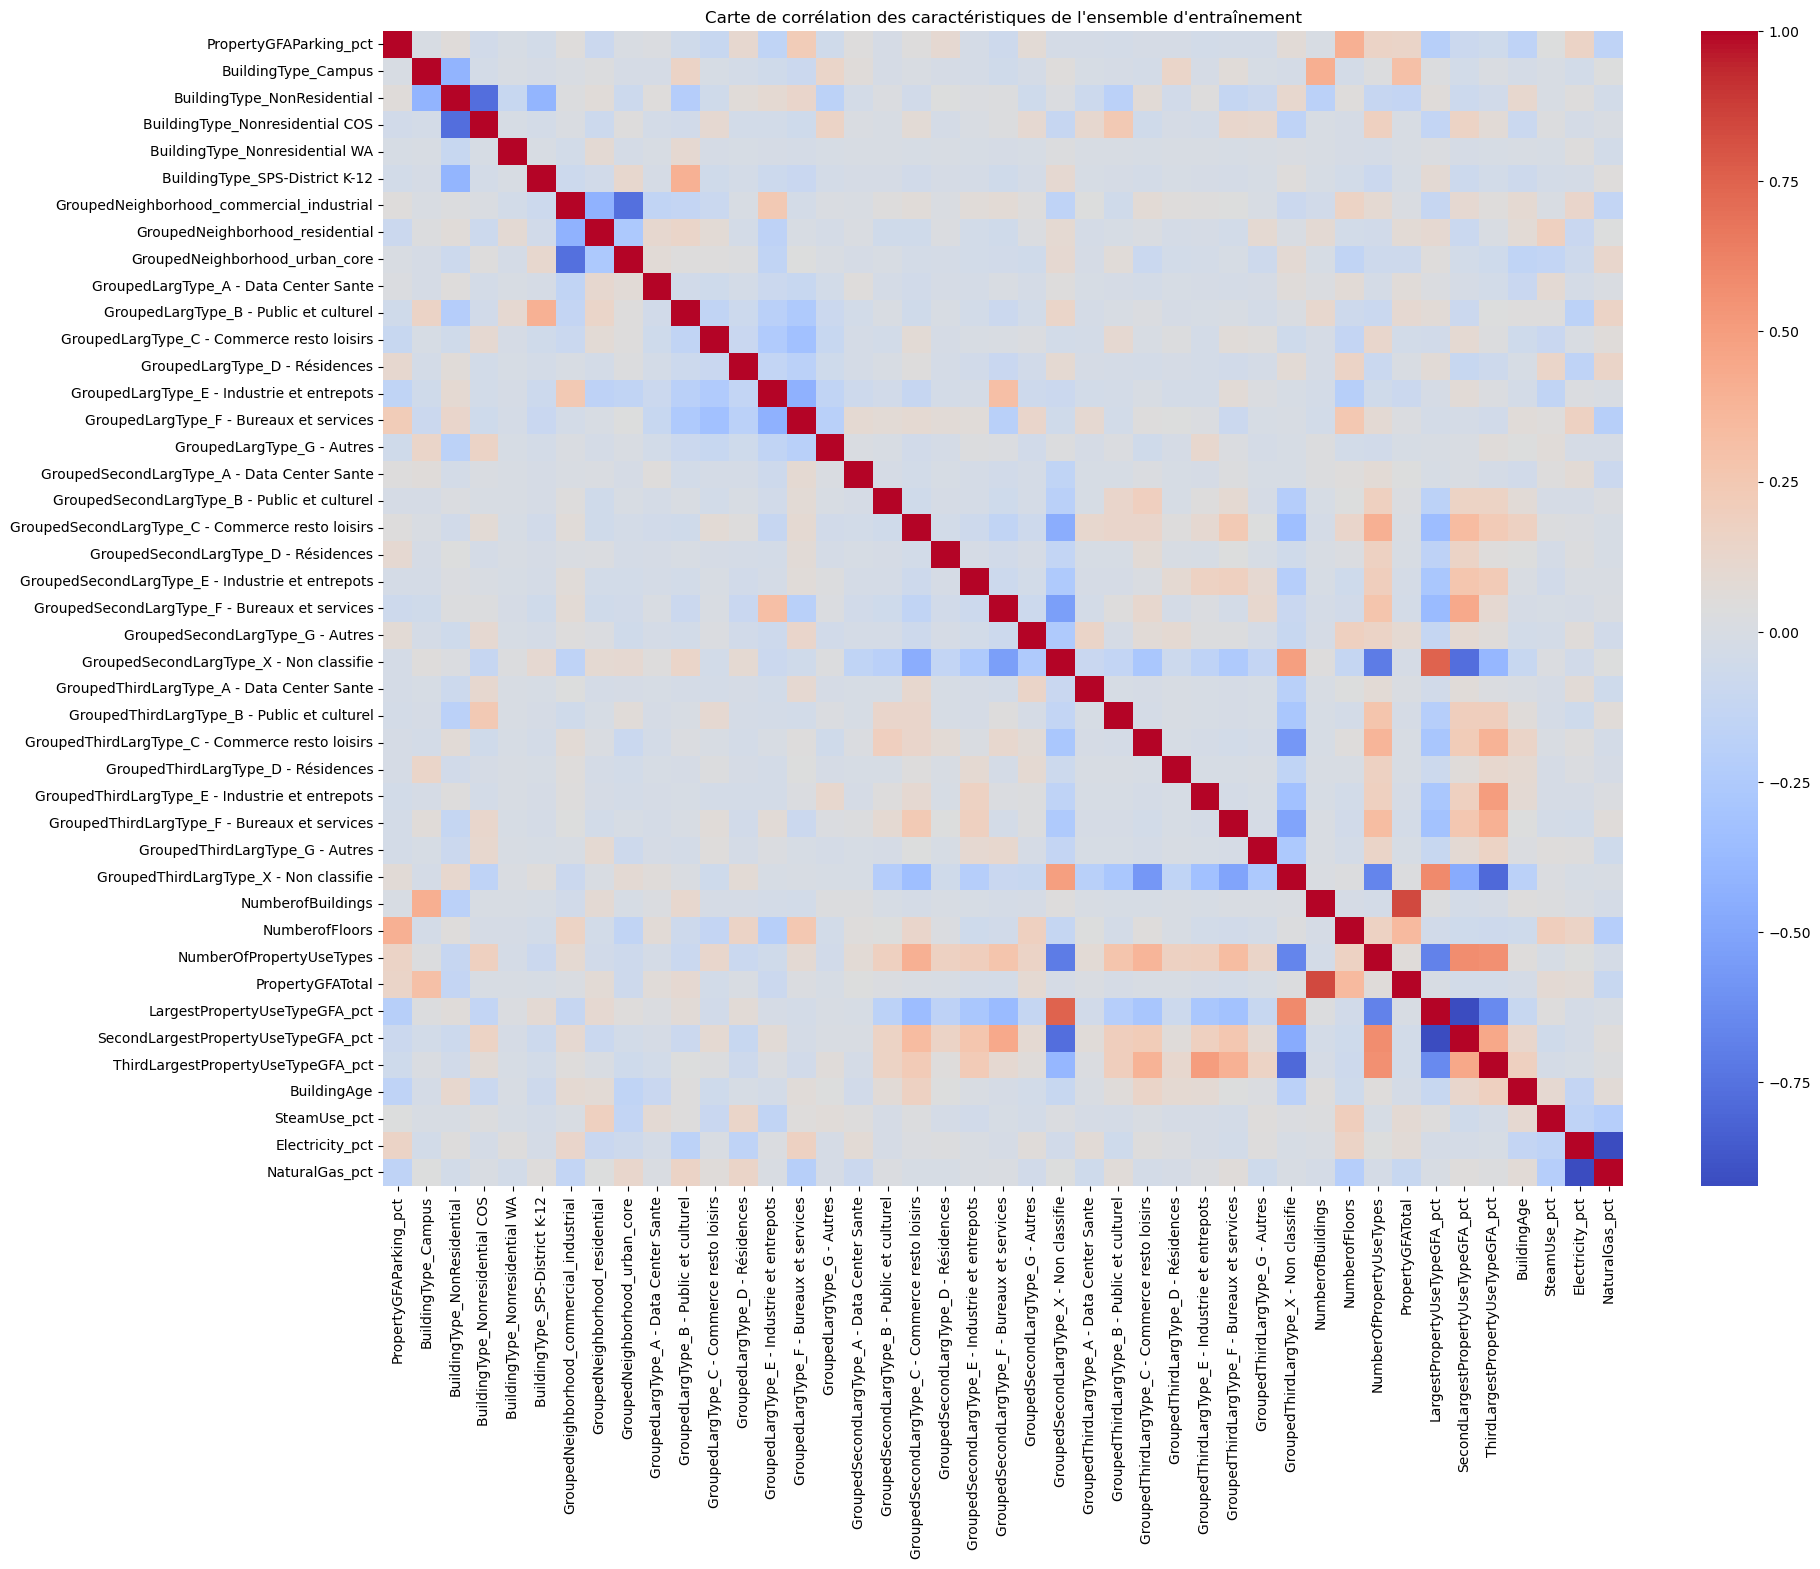

In [21]:
# Calcul de la matrice de corrélation pour l'ensemble d'entraînement préparé
corr_matrix = X_train_final.corr()

# Génération de la heatmap
plt.figure(figsize=(20, 15))  # Ajustez la taille selon le nombre de caractéristiques
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title('Carte de corrélation des caractéristiques de l\'ensemble d\'entraînement')
plt.show()


## Recherche des hyperparamètres

In [22]:
# Définition des hyperparamètres à tester
param_dist = {
    'n_estimators': np.arange(50, 300, 10),
    'learning_rate': np.linspace(0.008, 0.2, 20),
    'max_depth': np.arange(2, 10, 1),
    'min_samples_split': np.arange(2, 10, 1),
    'min_samples_leaf': np.arange(1, 5, 1),
    'subsample': np.linspace(0.5, 0.9, 20)
}

# Initialisation de la recherche aléatoire
random_search = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Exécution de la recherche aléatoire sur le jeu d'entraînement
random_search.fit(X_train_final, y_train)

# Récupération du meilleur modèle
best_gb_model = random_search.best_estimator_

# Affichage des meilleurs hyperparamètres
print(random_search.best_params_)

{'subsample': 0.6473684210526316, 'n_estimators': 260, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 4, 'learning_rate': 0.03831578947368421}


In [23]:
# Définition de la grille d'hyperparamètres
param_grid = {
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [300, 350, 400],
    'subsample': [0.5, 0.6, 0.7]
}

# Configuration de GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Exécution de la recherche d'hyperparamètres
grid_search.fit(X_train_final, y_train)

# Affichage des meilleurs paramètres
print("Meilleurs paramètres :", grid_search.best_params_)

# Prédiction avec le meilleur modèle
y_pred = grid_search.best_estimator_.predict(X_test_final)

# Calcul des métriques pour le meilleur modèle
rmse_hp = np.sqrt(mean_squared_error(y_test, y_pred))
r2_hp = r2_score(y_test, y_pred)
mae_hp = mean_absolute_error(y_test, y_pred)

print("RMSE :", rmse_hp)
print("R² :", r2_hp)
print("MAE :", mae_hp)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Meilleurs paramètres : {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.6}
RMSE : 0.576178163620348
R² : 0.7904224453225732
MAE : 0.44706048012159183


In [24]:
# Meilleurs hyperparamètres obtenus de GridSearchCV
best_params = grid_search.best_params_

# Configuration du modèle avec les meilleurs hyperparamètres
best_gb_model = GradientBoostingRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    subsample=best_params['subsample'],
    random_state=0
)

# Métriques à évaluer lors de la validation croisée
scoring_metrics = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']

# Exécution de la validation croisée (5 plis)
cv_results = cross_validate(best_gb_model, X_train_final, y_train, cv=5, scoring=scoring_metrics, return_train_score=True)

# Calcul et affichage des métriques moyennes pour chaque pli
rmse_scores = np.sqrt(-cv_results['test_neg_mean_squared_error'])
r2_scores = cv_results['test_r2']
mae_scores = -cv_results['test_neg_mean_absolute_error']

# Affichage avec écart type
print(f"Validation Croisée RMSE: {rmse_scores.mean():.4f} (± {rmse_scores.std():.4f})")
print(f"Validation Croisée R²: {r2_scores.mean():.4f} (± {r2_scores.std():.4f})")
print(f"Validation Croisée MAE: {mae_scores.mean():.4f} (± {mae_scores.std():.4f})")


Validation Croisée RMSE: 0.6453 (± 0.0429)
Validation Croisée R²: 0.7501 (± 0.0179)
Validation Croisée MAE: 0.4945 (± 0.0317)


In [25]:
best_gb_model.fit(X_train_final, y_train) 

# Prédictions sur l'ensemble d'entraînement
y_train_pred = best_gb_model.predict(X_train_final)

# Prédictions sur l'ensemble de test
y_test_pred = best_gb_model.predict(X_test_final)

# Calcul des métriques pour l'ensemble d'entraînement
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Calcul des métriques pour l'ensemble de test
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Affichage des métriques
print("Ensemble d'entraînement : RMSE = {:.4f}, R² = {:.4f}, MAE = {:.4f}".format(train_rmse, train_r2, train_mae))
print("Ensemble de test : RMSE = {:.4f}, R² = {:.4f}, MAE = {:.4f}".format(test_rmse, test_r2, test_mae))


Ensemble d'entraînement : RMSE = 0.3195, R² = 0.9395, MAE = 0.2470
Ensemble de test : RMSE = 0.5659, R² = 0.7979, MAE = 0.4417


## Evaluation de la performance

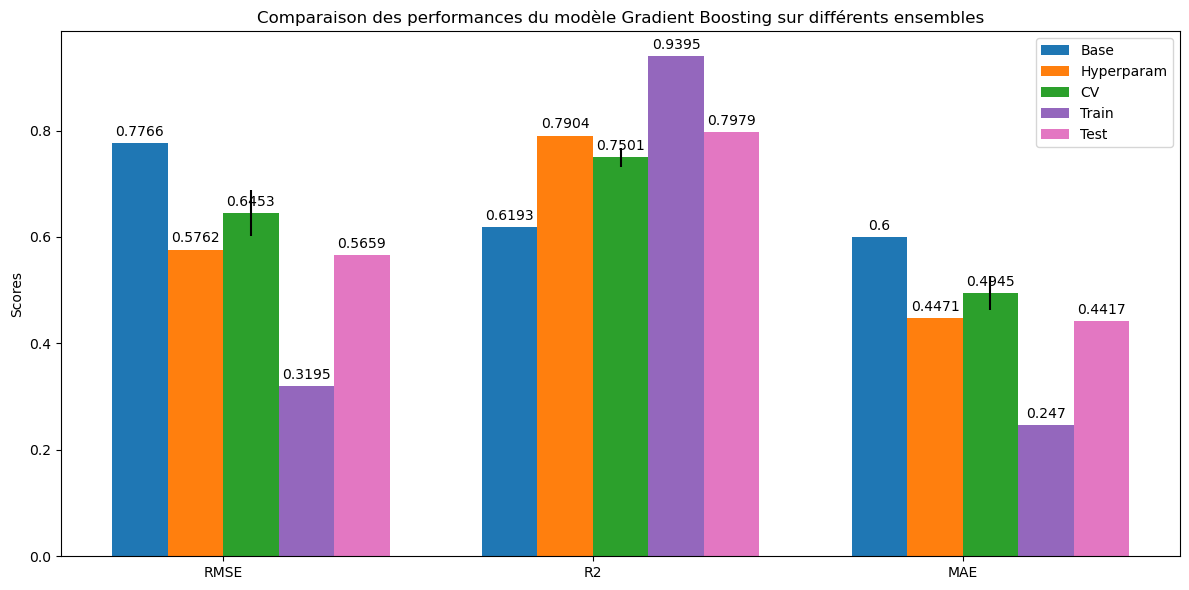

In [30]:
# Données pour le graphique
metrics = ['RMSE', 'R2', 'MAE']
base_performance = [rmse_base, r2_base, mae_base]
hp_performance = [rmse_hp, r2_hp, mae_hp]
cv_performance = [rmse_scores.mean(), r2_scores.mean(), mae_scores.mean()]
cv_std = [rmse_scores.std(), r2_scores.std(), mae_scores.std()]
train_performance = [train_rmse, train_r2, train_mae]
test_performance = [test_rmse, test_r2, test_mae]

# Configuration de l'axe x pour les groupes de barres
x = np.arange(len(metrics))  # emplacements des labels
width = 0.15 

# Couleurs de la palette tab10
colors_tab10 = plt.cm.tab10(np.arange(10))

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - (1.5 * width), base_performance, width, label='Base', color=colors_tab10[0])
rects2 = ax.bar(x - width/2, hp_performance, width, label='Hyperparam', color=colors_tab10[1])
rects3 = ax.bar(x + width/2, cv_performance, width, label='CV', yerr=cv_std, color=colors_tab10[2])
rects4 = ax.bar(x + (1.5 * width), train_performance, width, label='Train', color=colors_tab10[4])
rects5 = ax.bar(x + (2.5 * width), test_performance, width, label='Test', color=colors_tab10[6])

# Ajout des labels, titre et légende
ax.set_ylabel('Scores')
ax.set_title('Comparaison des performances du modèle Gradient Boosting sur différents ensembles')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Fonction pour attacher les labels aux barres
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # décalage vertical des labels
                    textcoords="offset points",
                    ha='center', va='bottom')

# Attacher les labels
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

# Afficher le graphique
plt.tight_layout()
plt.show()


## Analyse des erreurs

# Modélisation avec l'Energy Star Score

# Comparaison et conclusion